Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Skin Cancer Data
#### Reading data from google drive

### Importing all the important libraries

In [2]:
# import the required libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

In [3]:
# get to know the GPU if you are running in colab
!nvidia-smi

Sun Jul  4 16:44:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images

# using while running with google colab
data_dir_train = pathlib.Path("//content//drive//MyDrive//Dataset//Skin cancer ISIC The International Skin Imaging Collaboration//Train")
data_dir_test = pathlib.Path('//content//drive//MyDrive//Dataset//Skin cancer ISIC The International Skin Imaging Collaboration//Test')

# using to run locally
# data_dir_train = pathlib.Path("D:\\Machine Learning\\upGrad\\6_DeepLearning\\Module3\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train")
# data_dir_test = pathlib.Path("D:\\Machine Learning\\upGrad\\6_DeepLearning\\Module3\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test")

In [7]:
# print the number of images for train & test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
# prepare dataset for training with validation dataset of 20%, resize images to 180x180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset = "training"
    
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
# prepare dataset forvalidation with validation dataset of 20%, resize images to 180x180

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset = "validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

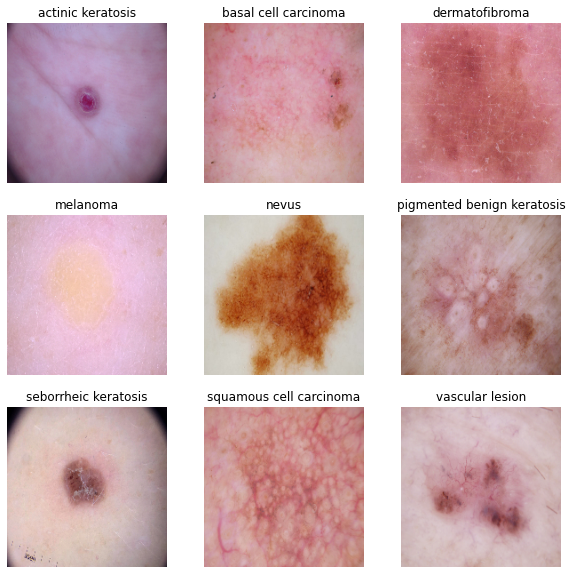

In [12]:
import matplotlib.pyplot as plt

# visualize the dataset, images will be shown for each class
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))

        plt.title(class_names[i])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### create CNN model with CNN & maxpool, use 'relu' activation
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
# compile the model using 'adam' optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [18]:
# train the model using 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 1s 22ms/step - loss: 0.2559 - accuracy: 0.9040 - val_loss: 2.4093 - val_accuracy: 0.5302
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 0.2334 - accuracy: 0.9079 - val_loss: 2.2296 - val_accuracy: 0.5414
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 0.1752 - accuracy: 0.9252 - val_loss: 2.3546 - val_accuracy: 0.5391
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 0.1536 - accuracy: 0.9230 - val_loss: 2.7101 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 0.1636 - accuracy: 0.9297 - val_loss: 2.3774 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 0.1449 - accuracy: 0.9319 - val_loss: 2.6087 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 0.1259 - accuracy: 0.9297 - val_loss: 2.4256 - val_accuracy: 0.5436
Epoch 8/20
56

### Visualizing training results

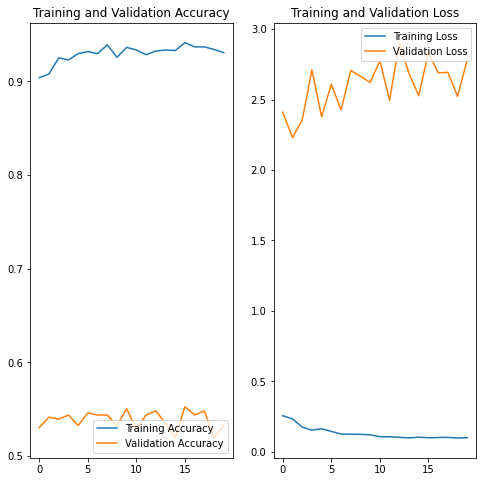

In [19]:
# visualize the accuracy for train & validation dataset
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings




*   The training accuracy is around 93.08
*   The validation accuracy is around 53.24
*   It clearly shows that model is <b>overfitting</b>. The model will not work well it is run on unseen data 









### Data Augmentation

In [20]:
# augment the dataset by flipping the images
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

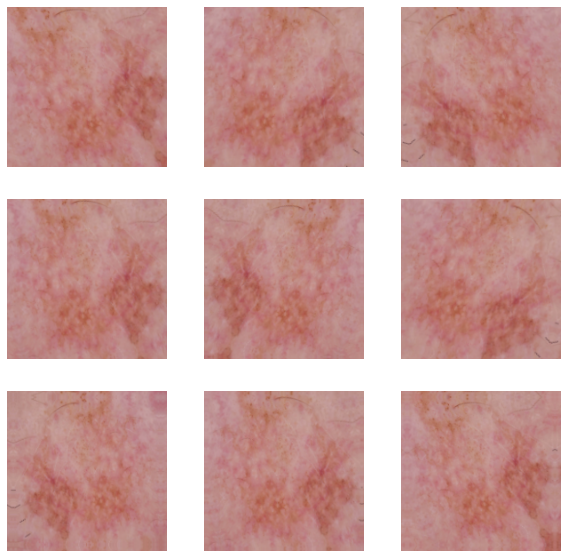

In [21]:
# visualize the augmented dataset
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off") 

In [22]:
# model using dropout layer since there was overfitting

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling Model

In [23]:
#compile the model using 'adam' optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
# display the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [27]:
# train the model using 20 epochs for augmented dataset
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 1s 24ms/step - loss: 0.7553 - accuracy: 0.7148 - val_loss: 1.4542 - val_accuracy: 0.5570
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 0.7391 - accuracy: 0.7277 - val_loss: 1.4326 - val_accuracy: 0.5817
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 0.7409 - accuracy: 0.7093 - val_loss: 1.5751 - val_accuracy: 0.5615
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 0.6840 - accuracy: 0.7349 - val_loss: 1.6376 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 0.7117 - accuracy: 0.7260 - val_loss: 1.6973 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 0.6981 - accuracy: 0.7450 - val_loss: 1.5870 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 0.6724 - accuracy: 0.7444 - val_loss: 1.6698 - val_accuracy: 0.5257
Epoch 8/20
56

### Visualization of the result

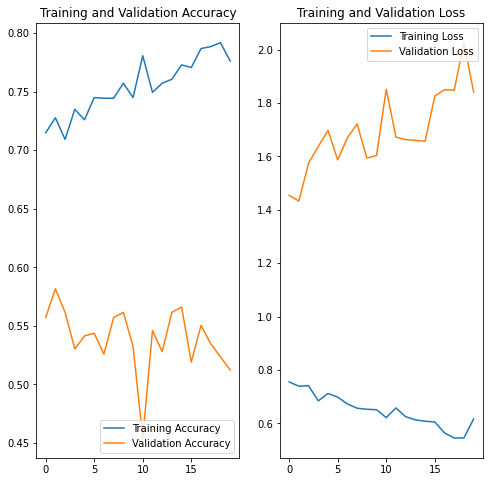

In [28]:
# visualize the accuracy for training & validation dataset
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:





*   The training accuracy is reduced compared to the previous model. The accuracy is around 77.20
*   The validation accuracy is around 51.25
*   The difference between training accuracy & validation accuracy is reduced but we have to increase both accuracies by adding more dataset








### Model 3

In [29]:
# prepare the model
temp_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=2239,
    image_size=(180, 180),
    shuffle=True,
    seed=123    
)

Found 2239 files belonging to 9 classes.


In [30]:
for images, labels in temp_train_ds:
    temp = labels.numpy()

In [31]:
data = pd.DataFrame(temp,columns=class_names)

In [33]:
# display the data
data

,actinic keratosis,basal cell carcinoma,dermatofibroma,melanoma,nevus,pigmented benign keratosis,seborrheic keratosis,squamous cell carcinoma,vascular lesion
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2236,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [34]:
# display the details for each class
for col in data.columns:
    print(f"{col}\n", data[col].value_counts(ascending=True))
    print('---------------------------------------')

actinic keratosis
 1.0     114
0.0    2125
Name: actinic keratosis, dtype: int64
---------------------------------------
basal cell carcinoma
 1.0     376
0.0    1863
Name: basal cell carcinoma, dtype: int64
---------------------------------------
dermatofibroma
 1.0      95
0.0    2144
Name: dermatofibroma, dtype: int64
---------------------------------------
melanoma
 1.0     438
0.0    1801
Name: melanoma, dtype: int64
---------------------------------------
nevus
 1.0     357
0.0    1882
Name: nevus, dtype: int64
---------------------------------------
pigmented benign keratosis
 1.0     462
0.0    1777
Name: pigmented benign keratosis, dtype: int64
---------------------------------------
seborrheic keratosis
 1.0      77
0.0    2162
Name: seborrheic keratosis, dtype: int64
---------------------------------------
squamous cell carcinoma
 1.0     181
0.0    2058
Name: squamous cell carcinoma, dtype: int64
---------------------------------------
vascular lesion
 1.0     139
0.0    21

In [35]:
# display the different class names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [36]:
# install Augmentor
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [37]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset)+'/'+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to //content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F923C57D5D0>: 100%|██████████| 500/500 [00:19<00:00, 26.30 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to //content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F923C4EAF90>: 100%|██████████| 500/500 [00:18<00:00, 27.17 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to //content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F923C1DCA90>: 100%|██████████| 500/500 [00:19<00:00, 25.23 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to //content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F923C221F90>: 100%|██████████| 500/500 [01:47<00:00,  4.67 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F923C17A810>:   0%|          | 1/500 [00:00<01:07,  7.45 Samples/s]

Initialised with 357 image(s) found.
Output directory set to //content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=853x680 at 0x7F923C180510>: 100%|██████████| 500/500 [01:13<00:00,  6.80 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to //content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F923C193150>: 100%|██████████| 500/500 [00:19<00:00, 25.03 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to //content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F923C1B86D0>: 100%|██████████| 500/500 [00:41<00:00, 12.05 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to //content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F923C26A050>: 100%|██████████| 500/500 [00:19<00:00, 26.29 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to //content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F93055083D0>: 100%|██████████| 500/500 [00:19<00:00, 25.68 Samples/s]


In [38]:
# display count of images
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [39]:
path_list_old = [x for x in glob.glob(os.path.join(data_dir_train,'*','*.jpg'))]

In [40]:
path_list_old[115:119]

['//content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0027046.jpg',
 '//content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0026798.jpg',
 '//content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0025824.jpg',
 '//content/drive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0026902.jpg']

In [41]:
# display length
len(path_list_old)

2239

In [42]:
lesion_list_old = [os.path.basename(os.path.dirname(y)) \
                   for y in glob.glob(os.path.join(data_dir_train,'*','*.jpg'))]

In [43]:
lesion_list_old[1:5]

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma']

In [44]:
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])


In [45]:
# display different counts
original_df["Label"].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [46]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [47]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[1:5]

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma']

In [48]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))


In [49]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [50]:
# count of new dataset
new_df["Label"].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [51]:
batch_size = 32
img_height = 180
img_width = 180

In [52]:
# prepare the train model
data_dir_train= data_dir_train #"path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [53]:
# prepare validation model
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [54]:
# build CNN model using CNN & maxpool
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [55]:
# compile teh model using 'adam' optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
# display 3rd model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

In [57]:
epochs = 50
# train the model using 50 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 32s 180ms/step - loss: 1.9295 - accuracy: 0.2715 - val_loss: 1.6441 - val_accuracy: 0.4143
Epoch 2/50
169/169 [==============================] - 31s 177ms/step - loss: 1.4503 - accuracy: 0.4551 - val_loss: 1.3660 - val_accuracy: 0.4944
Epoch 3/50
169/169 [==============================] - 31s 178ms/step - loss: 1.2547 - accuracy: 0.5317 - val_loss: 1.2188 - val_accuracy: 0.5479
Epoch 4/50
169/169 [==============================] - 31s 178ms/step - loss: 1.0714 - accuracy: 0.6111 - val_loss: 1.0866 - val_accuracy: 0.5924
Epoch 5/50
169/169 [==============================] - 31s 176ms/step - loss: 0.9103 - accuracy: 0.6697 - val_loss: 1.1070 - val_accuracy: 0.5999
Epoch 6/50
169/169 [==============================] - 31s 176ms/step - loss: 0.7432 - accuracy: 0.7348 - val_loss: 0.8991 - val_accuracy: 0.6704
Epoch 7/50
169/169 [==============================] - 31s 175ms/step - loss: 0.6213 - accuracy: 0.7747 - val_loss: 0.8716 - val_ac

#### Visualize the accuracy

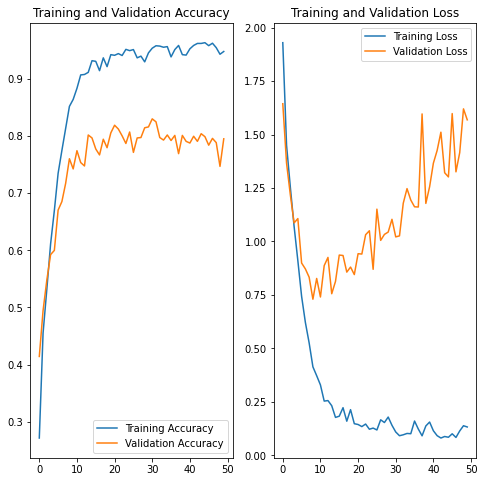

In [58]:
# display the training & validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:

*   The training accuracy has improved from the 2nd model. It is now 94.79
*   Validation accuracy also improved from 2nd model. It is now 79.51
*   After rebalancing using Augmentation the classes are balanced & we are getting better results.
*   If more dataset is added we would certainly get better training & validation results.

